In [3]:
import pandas as pd
import geopandas
%matplotlib inline

In [ ]:
# need to install rtree in order for geopandas.sjoin to work
import sys
!{sys.executable} -m pip install rtree

In [4]:
# read the csv, only uses the needed columns, emissions and the address
emissions = pd.read_csv("PittsburghEnergy.csv", usecols=["Address 1","Total GHG Emissions (Metric Tons CO2e)"])
# Adds more detail to the addresses so the geocoder can discern the coordinates
emissions["Address 1"] = emissions["Address 1"].astype(str) + ", Pittsburgh, Pennsylvania, United States"
# the csv contains data from 6 different years, this makes sure we are only looking at the most current year
emissions = emissions[::6]

# uses geopandas geocoding to find the longitude and latitude of each address
the_locations = geopandas.tools.geocode(emissions["Address 1"], provider='nominatim', user_agent="Pittsburgh Emissions")
# Transfers the emissions column from the old data frame to the new dataframe
the_locations["Emissions"] = emissions["Total GHG Emissions (Metric Tons CO2e)"]

In [11]:
import matplotlib.pyplot as plt
# reads the shapefile
pittsburgh = geopandas.read_file("maps/Neighborhoods_.shp")

# sets coordinate system
pittsburgh.to_crs("EPSG:4326")
#  combines the map with the coordinates by figuring out which coordinates are in which neighborhoods.
emissions_map = geopandas.sjoin(pittsburgh, the_locations, how ="inner")

# Used this to create the file that is used for the finalized plots:
# emissions_map.to_file("emissions.csv", driver="CSV")

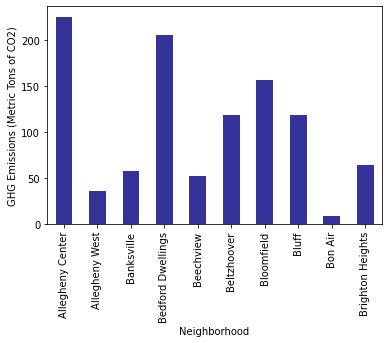

In [17]:
# reads the new csv, looks at only the neighborhoods and emissions
emissions_thing = pd.read_csv("emissions.csv", usecols=["hood","Emissions"])
# Makes sure all the emission values are summed for the neighborhoods
emissions_vals = emissions_thing.groupby("hood").sum()['Emissions']
# sorts the values in ascending order
emissions_vals.sort_values(ascending=True)
# plots on bar graph of the 10 smallest Emissions values
emissions_vals.head(10).plot(kind = "bar", x="hood", y="emissions", xlabel="Neighborhood", ylabel="GHG Emissions (Metric Tons of CO2)",
                            colormap = "terrain")

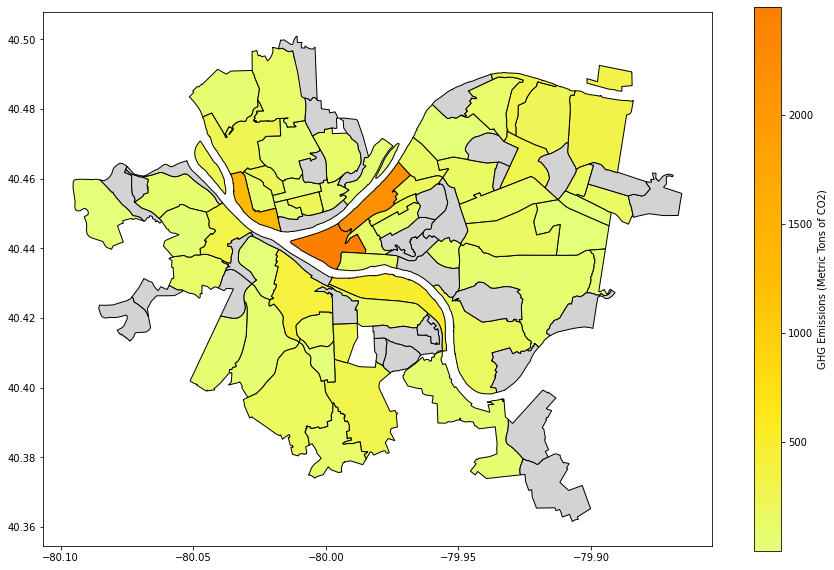

In [10]:
# plots the map. More orange = more GHG emissions, more green = less. Grey = No data
emissions_map = pittsburgh.merge(emissions_vals, how='left', left_on='hood', right_on='hood')
emissions_map.plot(column='Emissions', cmap="Wistia", edgecolor="black", figsize=(15,10), legend= True, 
                   legend_kwds={'label': "GHG Emissions (Metric Tons of CO2)"}, missing_kwds={"color": "lightgrey"})